In [14]:
from typing import Union, Callable
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from time import sleep

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [26]:
class Dataset(data.Dataset):

    def __init__(self, X: np.array, y: np.array):
        self.X, self.y = X, y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]

def data_loaders(X: Union[np.ndarray, torch.Tensor], y: Union[np.ndarray, torch.Tensor], test_size: float = 0.2, random_state: Union[int, None] = None, batch_size: int = 32, *args, **kwargs):

    assert X.shape[0] == y.shape[0]

    if isinstance(X, np.ndarray):
        X = torch.Tensor(X)
    if isinstance(y, np.ndarray):
        y = torch.Tensor(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=random_state)
    train_loader = data.DataLoader(
        dataset=Dataset(X_train, y_train),
        batch_size=batch_size,
        shuffle=True
    )
    test_loader = data.DataLoader(
        dataset=Dataset(X_test, y_test),
        batch_size=batch_size,
        shuffle=True
    )

    return train_loader, test_loader

In [67]:
class FNN(nn.Module):

    def __init__(self, n_hidden_layers_sizes: Union[int, list] = 1, activation: str = 'sigmoid', *args, **kwargs):

        super(FNN, self).__init__()

        if isinstance(n_hidden_layers_sizes, int):
            n_hidden_layers_sizes = [n_hidden_layers_sizes]
        if not isinstance(n_hidden_layers_sizes, list):
            raise ValueError(f'n_hidden_layers_sizes should be of type int or list, instead received {n_hidden_layers_sizes} of type {type(n_hidden_layers_sizes)}.')
        
        n_hidden_layers_sizes = [1] + n_hidden_layers_sizes + [1]
        self.dense_layers = nn.Sequential(*[
            nn.Linear(input_size, output_size) 
            for input_size, output_size in zip(n_hidden_layers_sizes[:-1], n_hidden_layers_sizes[1:])
        ])

        if activation.lower() == 'relu':
            self.activation = nn.ReLU()
        elif activation.lower() == 'gelu':
            self.activation = nn.GELU()
        elif activation.lower() == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            raise ValueError(f'activation must be one of relu, gelu or sigmoid, instead received {activation}')

    def forward(self, x: torch.Tensor):

        for layer in self.dense_layers[:-1]:
            x = self.activation(layer(x))

        output = self.dense_layers[-1](x)

        return output

In [68]:
def train(model, train_loader, criterion, optimizer, scheduler, to_print):
    
    model.train()
    train_loss = []
    
    for data in train_loader:
        
        X, y = data 
        output = model(X)
        loss = criterion(output, y)
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = torch.mean(torch.tensor(train_loss))

    if to_print:
        print(f'Average training loss = {avg_train_loss:.4f}', end=', ')
    
    return avg_train_loss

def test(model, train_loader, criterion, to_print):
    
    model.eval()
    test_loss = []
    
    for data in train_loader:
        
        X, y = data 
        output = model(X)
        loss = criterion(output, y)
        test_loss.append(loss.item())

    avg_test_loss = torch.mean(torch.tensor(test_loss))

    if to_print:
        print(f'Average validation loss = {avg_test_loss:.4f}')
    
    return avg_test_loss

In [102]:
def main(X: np.ndarray, y1: np.ndarray, test_size: float = 0.2, batch_size: int = 32, n_hidden_layers_sizes: Union[int, list] = [3, 3], activation: str = 'sigmoid', epochs: int = 100, lr: float = 2e-4):

    assert isinstance(test_size, float) and 0 < test_size < 1
    assert isinstance(batch_size, int) and batch_size > 0
    assert isinstance(activation, str) and activation in ('sigmoid', 'ReLU', 'GELU')
    assert isinstance(epochs, int) and epochs > 0
    assert isinstance(lr, float) and 0 < lr

    y = y1 + np.random.normal(0, 1, X.shape[0])
    train_loader, test_loader = data_loaders(X, y, test_size=test_size, batch_size=batch_size)

    model = FNN(n_hidden_layers_sizes=n_hidden_layers_sizes, activation=activation)

    optimizer = optim.AdamW(model.parameters(), lr)
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=lr, 
        steps_per_epoch=len(train_loader),
        epochs=epochs,
        anneal_strategy='linear'
    )

    train_stats, test_stats = [], []

    for epoch in range(1, epochs+1):

        to_print = not bool(epoch%5)
        if to_print:
            print(f'Epoch: {epoch}', end=' - ')

        train_loss = train(model, train_loader, criterion, optimizer, scheduler, to_print)
        test_loss = test(model, test_loader, criterion, to_print)

        train_stats.append(train_loss)
        test_stats.append(test_loss)

    return model, train_stats, test_stats

In [103]:
def plot(X, y1, model, train_stats, test_stats):

    fontdict = {'family':'serif', 'color':'darkred', 'weight':'normal', 'size':16}
    labelpad = titlepad = 12

    _, axs = plt.subplots(1, 2, figsize=(16, 6))
    axs[0].set_xlabel('Epochs', fontdict=fontdict, labelpad=labelpad)
    axs[0].set_ylabel('Loss', fontdict=fontdict, labelpad=labelpad)
    axs[0].set_title('Training Loss and Test Loss', fontdict=fontdict, pad=titlepad)
    axs[0].plot(train_stats, color='g', label='Training')
    axs[0].plot(test_stats, color='b', label='Validation')
    axs[0].legend()
    axs[0].grid()

    X = torch.Tensor(X)
    y2 = model(X).detach().numpy()

    axs[1].set_xlabel('X', fontdict=fontdict, labelpad=labelpad)
    axs[1].set_ylabel('Y', fontdict=fontdict, labelpad=labelpad)
    axs[1].set_title('True Value and Model Predictions', fontdict=fontdict, pad=titlepad)
    axs[1].plot(X, y1, color='g', label='True Value')
    axs[1].plot(X, y2, color='b', label='Model Predictions')
    axs[1].legend()
    axs[1].grid()

Epoch: 5 - Average training loss = 9.4879, Average validation loss = 11.2522
Epoch: 10 - Average training loss = 9.4117, Average validation loss = 11.1217
Epoch: 15 - Average training loss = 9.2959, Average validation loss = 11.4649
Epoch: 20 - Average training loss = 9.1588, Average validation loss = 10.5668
Epoch: 25 - Average training loss = 9.0447, Average validation loss = 10.3489
Epoch: 30 - Average training loss = 8.9579, Average validation loss = 10.4431
Epoch: 35 - Average training loss = 8.8931, Average validation loss = 10.9382
Epoch: 40 - Average training loss = 8.8452, Average validation loss = 10.2534
Epoch: 45 - Average training loss = 8.8102, Average validation loss = 10.1075
Epoch: 50 - Average training loss = 8.7867, Average validation loss = 10.6025
Epoch: 55 - Average training loss = 8.7727, Average validation loss = 10.0609
Epoch: 60 - Average training loss = 8.7676, Average validation loss = 10.4164


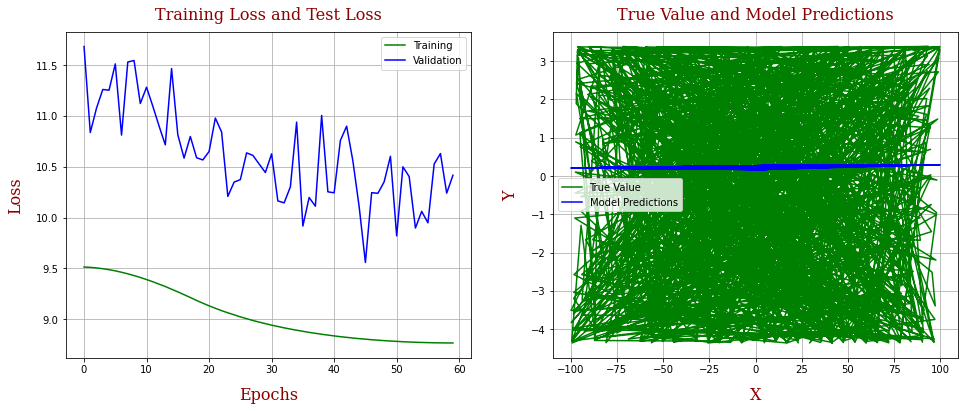

In [104]:
a, b, c, d = np.random.normal(loc=0, scale=2, size=4)
transform = np.vectorize(lambda x: a * np.sin(b*x + c) + d)

X = np.random.uniform(-100, 100, 1000).reshape((-1, 1))
y1 = transform(X)

model, train_stats, test_stats = main(X, y1, n_hidden_layers_sizes=[5], epochs=60)
plot(X, y1, model, train_stats, test_stats)

Epoch: 5 - Average training loss = nan, Average validation loss = nan
Epoch: 10 - Average training loss = nan, Average validation loss = nan
Epoch: 15 - Average training loss = nan, Average validation loss = nan
Epoch: 20 - Average training loss = nan, Average validation loss = nan
Epoch: 25 - Average training loss = nan, Average validation loss = nan
Epoch: 30 - Average training loss = nan, Average validation loss = nan
Epoch: 35 - Average training loss = nan, Average validation loss = nan
Epoch: 40 - Average training loss = nan, Average validation loss = nan
Epoch: 45 - Average training loss = nan, Average validation loss = nan
Epoch: 50 - Average training loss = nan, Average validation loss = nan
Epoch: 55 - Average training loss = nan, Average validation loss = nan
Epoch: 60 - Average training loss = nan, Average validation loss = nan


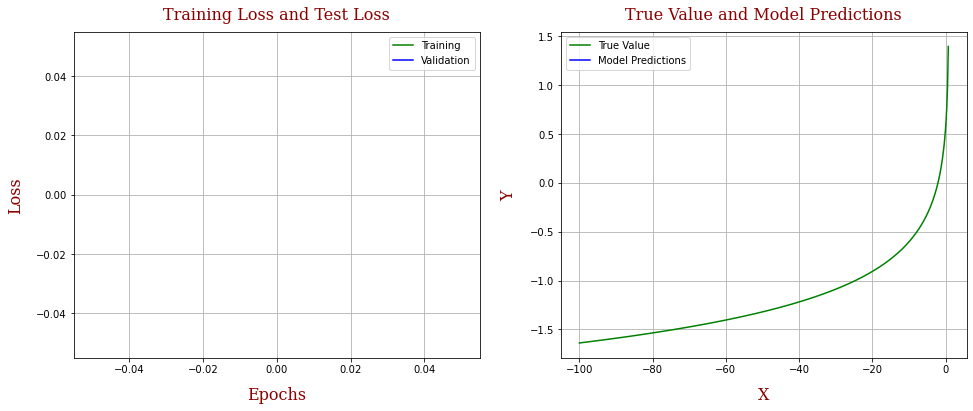

In [85]:
a, b, c, d = np.random.normal(loc=0, scale=2, size=4)
transform = np.vectorize(lambda x: a * np.log(b*x + c) + d)

n_data_points = 1000
model, train_stats, test_stats = main(n_data_points=n_data_points, transform=transform, n_hidden_layers_sizes=[5], epochs=60)
plot(model, train_stats, test_stats, n_data_points, transform)

In [84]:
a, b, c, d

(-2.591260932872156,
 -4.19741653724682,
 -0.05895025698549589,
 0.3527994830749958)